In [1]:
!pip install -q langchain langchain_groq langchain_community langgraph rizaio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.6 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import os

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
os.environ['RIZA_API_KEY'] = userdata.get('RIZA_API_KEY')

In [3]:
from typing import Annotated, Sequence, List, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.riza.command import ExecPython
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from pprint import pprint
from IPython.display import Image, display

In [4]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [5]:
llm.invoke("hi").content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

# Define Tools

In [6]:
tool_tavily = TavilySearchResults(max_results=2)

tool_code_interpreter = ExecPython()

tools = [tool_tavily, tool_code_interpreter]

# Define our Supervisor Agent

In [7]:
system_prompt = ('''You are a workflow supervisor managing a team of three agents: Prompt Enhancer, Researcher, and coder.
Your role is to direct the flow of tasks by selecting the next agent based on the current stage of the workflow.
For each task, provide a clear rationale for your choice, ensuring that the workflow profresses logically, efficiently, and toward a timely completion.

**Team Members**:
1. Enhancer: Use prompt enhancer as the first preference, to Focus on clarifying vague or incomplete user queries,
  and ensuring they are well-defined before further processing.
2. Researcher: Specializes in gathering information.
3. Coder: Handles technical tasks related to calculation, coding, data analysis, and problem-solving, ensuring
  the correct implementation of solutions.

**Responsibilities**:
1. Carefully review each user request and evaluate agent responses for relevance and completeness.
2. Continuously route tasks to the next best-suited agent if needed.
3. Ensure the workflow progresses efficiently, without terminating until the task is fully resolved.

Your goal is to maximize accuracy and effectiveness by leveraging each agent's unique expertise while ensuring smooth workflow execution.
''')


class Supervisor(BaseModel):
  next: Literal["enhancer", "researcher", "coder"] = Field(
      description = "Specifies the next worker in the pipeline: "
                    "'enhancer' for enhancing the user prompt if it is unclear or vague,"
                    "'researcher' for additional information gathering, "
                    "'coder' for solving technical or code-related problems."
  )
  reason: str = Field(
      description = "The reason for the decision, providing context on why a particular worker was chosen."
  )


def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder"]]:
  """
  Supervisor node for routing tasks based on the current state and LLM response.
  Args:
    state (MessageState): The current state containing message history.
  Returns:
    command: A command indicating the next state or action.
  """

  # Prepare messages by appending the system prompt to the message history
  messages = [
      {"role": "system", "content": system_prompt},
  ] + state['messages']  # Append previous messages from the state

  response = llm.with_structured_output(Supervisor).invoke(messages)

  goto = response.next
  reason = response.reason

  print(f"Current Node: Supervisor -> Goto: {goto}")

  return Command(
      update = {
          "messages": [
              # Append the reason (supervisor's response) to the state, tagged with "supervisor"
              HumanMessage(content=reason, name="supervisor")
          ]
      },
      goto = goto, # Specify the next node in the workflow
  )

In [8]:
def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:
  """
  Enhancer node for refining and clarifying user inputs.

  Args:
    state (MessageState): The current state containing conversation history.

  Returns:
    command: A command to update the state with the enhanced query and route back to the supervisor.
  """

  system_prompt = (
      "You are an advanced query enhancer. Your task is to: \n"
      "Don't ask anything to the user, select the most appropriate prompt"
      "1. Clarify and refine user inputs."
      "2. Identify any ambiguities in the query. \n"
      "3. Generate a more precise and actionable version of the original request.\n"
  )

  # Combine the system prompt with the current conversation messages
  messages = [
      {"role": "system", "content": system_prompt}
  ] + state["messages"] # Include the conversation history for context

  enhanced_query = llm.invoke(messages)
  print(f"Current Node: Prompt Enhancer -> Goto: Supervisor")

  # Return a command to update the state with the enhanced query and route back to the supervisor
  return Command(
      update = {
          "messages": [
              HumanMessage(
                  content=enhanced_query.content,
                  name="enhancer"
              )
          ]
      },
      goto = "supervisor" # Route to the supervisor for further processing
  )

In [32]:
def research_node(state: MessagesState) -> Command[Literal["validator"]]:
  """
  Research node for leveraging a ReAct agent to process research-related tasks.

  Args:
    state (MessagesState): The current state containing the conversation history.

  Returns:
    Command: A command to update the state with the research results and route to the validator.
  """
  # Create a ReAct agent specialized for research tasks
  research_agent = create_react_agent(
      llm,
      tools = [tool_tavily],
      state_modifier="You are a researcher. Focus on gathering information and generating content. \
      Do not perform any other tasks"  # Instruction to restrict the agent's behaviour
  )

  result = research_agent.invoke(state)
  print(f"Current Node: Researcher -> Goto: Validator")

  return Command(
      update = {
          "messages": [
              HumanMessage(
              content = result['messages'][-1].content,
              name = "researcher"
              )
          ]
      },
      goto = "validator",
  )

In [33]:
def code_node(state: MessagesState) -> Command[Literal["validator"]]:
  """
  Coder node for leveraging a ReAct agent to process analyzing, solving math questions, and executing code.

  Args:
    state (MessageState): The current state containing the conversation history.

  Returns:
    Command: A command to update the state with the coder's response and route to the validator.
  """
  # Create a specialized ReAct agent for coding and problem-solving tasks
  code_agent = create_react_agent(
      llm,
      tools=[tool_code_interpreter],
      state_modifier=(
          "You are a coder and analyst. Focus on mathematical calculations, analyzing, solving math questions,"
          " and executing code. Handle technical problem-solving and data tasks."
      )
  )

  result = code_agent.invoke(state)

  print(f"Current Node: Coder -> Goto: Validator")

  return Command(
      update = {
          "messages": [
              HumanMessage(content=result['messages'][-1].content, name="coder")
          ]
      },
      goto = "validator",
  )

In [34]:
# System prompt providing clear instructions to the validator agent
system_prompt = """
You are a workflow validator. Your task is to ensure the quality of the workflow. Specifically, you must:
- Review the user's question (the first message in the workflow)
- Review the answer (the last message in the workflow.)
- If the answer satisfactorily addresses the question, signal to end the workflow.
- If the answer is inappropriate or incomplete, signal to route back to the supervisor for re-evaluation or further refinement.
Ensure that the question and answer match logically and the workflow can be concluded or continued based on this evaluation.

Routing Guidelines:
1. 'supervisor' Agent: For unclear or vegue state messages.
2. Respond with 'FINISH' to end the workflow.
"""

class Validator(BaseModel):
  next: Literal["supervisor", "FINISH"] = Field(
      description = "Specifies the next worker in the pipeline: 'supervisor' to continue or \
        'FINISH' to terminate"
  )
  reason: str = Field(
      description = "The reason for the decision."
  )


def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:
  """
  Validator node for checking if the question and answer are appropriate.

  Args:
  state (MessageState): The current state containing message history.

  Returns:
    Command: A command indicating whether to route back to the supervisor or end the workflow.
  """

  user_question = state['messages'][0].content
  agent_answer = state['messages'][-1].content

  messages = [
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": user_question},
      {"role": "assistant", "content": agent_answer}
  ]

  response = llm.with_structured_output(Validator).invoke(messages)

  goto = response.next
  reason = response.reason

  if goto == "FINISH" or goto == END:
    goto = END
    print("Transitioning to END")
  else:
    print(f"Current Node: Validator -> Goto: Supervisor")

  return Command(
      update = {
          "messages": [
              HumanMessage(content=reason, name="validator")
          ]
      },
      goto = goto
  )

In [35]:
builder = StateGraph(MessagesState)

builder.add_node("supervisor", supervisor_node)
builder.add_node("enhancer", enhancer_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
builder.add_node("validator", validator_node)

builder.add_edge(START, "supervisor")

graph = builder.compile()


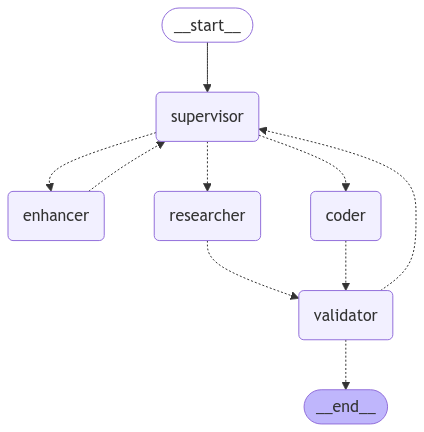

In [36]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [37]:
import pprint

inputs = {
    "messages": [
        ("user", "wheather in chicago?")
    ]

}

for output in graph.stream(inputs):
  for key, value in output.items():
    if value is None:
      continue
    pprint.pprint(f"Output from node '{key}':")
    pprint.pprint(value, indent=2, width=80, depth=None)
    print()

Current Node: Supervisor -> Goto: researcher
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user's question about the weather in Chicago is unclear and requires additional information gathering to provide an accurate answer.", additional_kwargs={}, response_metadata={}, name='supervisor', id='bd734bf7-79dc-4ead-a921-222cfa5c91c6')]}

Current Node: Researcher -> Goto: Validator
"Output from node 'researcher':"
{ 'messages': [ HumanMessage(content='The current weather in Chicago is partly cloudy with a temperature of -9.3°C (15.3°F) and a wind speed of 8.7 mph (14.0 kph). The condition is expected to be cloudy with overcast skies throughout the day.', additional_kwargs={}, response_metadata={}, name='researcher', id='836a055a-1b2f-4585-84bb-dca15012c43c')]}

Transitioning to END
"Output from node 'validator':"
{ 'messages': [ HumanMessage(content='The answer provides relevant information about the weather in Chicago.', additional_kwargs={}, response_metadata={

In [38]:
inputs = {
    "messages": [
        ("user", "what is difference between the stock price of apple in 2023 and 2021?"),
    ]
}

# Stream through the graph and get output
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        # Get the last message from the output
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()


Current Node: Supervisor -> Goto: researcher
"Output from node 'supervisor':"
HumanMessage(content='To find the difference between the stock price of Apple in 2023 and 2021, we need to gather the historical stock prices for Apple for these two years.', additional_kwargs={}, response_metadata={}, name='supervisor', id='fd8e6511-22fc-4ffc-a8d1-13738aa15d15')

Current Node: Researcher -> Goto: Validator
"Output from node 'researcher':"
HumanMessage(content='The difference between the stock price of Apple in 2023 and 2021 is approximately $32.73, with the stock price increasing from $191.80 in 2021 to $224.53 in 2023, representing a 46.7% increase.', additional_kwargs={}, response_metadata={}, name='researcher', id='740b7a18-e0f5-4078-8459-113a4be0fcfe')

Transitioning to END
"Output from node 'validator':"
HumanMessage(content='The answer satisfactorily addresses the question by providing the difference in stock price between 2023 and 2021.', additional_kwargs={}, response_metadata={}, na

In [39]:
inputs = {
    "messages": [
        ("user", "Research the impact of climate change on agriculture in Southeast Asia. Based on your findings, propose potential solutions to mitigate its effects on crop production"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

Current Node: Supervisor -> Goto: researcher
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user's question requires additional information gathering on the impact of climate change on agriculture in Southeast Asia to provide a comprehensive answer.", additional_kwargs={}, response_metadata={}, name='supervisor', id='5ffd0bd0-4928-44b6-bdf2-495ae8e4e14b')]}

Current Node: Researcher -> Goto: Validator
"Output from node 'researcher':"
{ 'messages': [ HumanMessage(content='Based on the search results, it appears that climate change is having a significant impact on agriculture in Southeast Asia, with droughts being a major concern. The region is experiencing temporal and spatial changes in drought conditions, which are affecting crop production. To mitigate the effects of climate change on agriculture in Southeast Asia, potential solutions could include:\n\n1. Implementing drought-resistant crop varieties and irrigation systems to reduce the impact of droughts

In [40]:
inputs = {
    "messages": [
        ("user", "give me how many A's present in a string of AVYGABAAHKJHDAAAAUHBU  ?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

Current Node: Supervisor -> Goto: coder
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user's question requires a technical solution to count the number of 'A's in a given string.", additional_kwargs={}, response_metadata={}, name='supervisor', id='5dd88988-7862-4b7a-addf-6ce16b808c33')]}

Current Node: Coder -> Goto: Validator
"Output from node 'coder':"
{ 'messages': [ HumanMessage(content='The string "AVYGABAAHKJHDAAAAUHBU" contains 8 \'A\'s.', additional_kwargs={}, response_metadata={}, name='coder', id='f0e29749-d80e-4dfe-b5f4-d405bec7cadc')]}

Transitioning to END
"Output from node 'validator':"
{ 'messages': [ HumanMessage(content='The answer satisfactorily addresses the question.', additional_kwargs={}, response_metadata={}, name='validator', id='9fe33476-e527-4fa8-a89e-9ccec00b5b7a')]}

